# Analysis of $n_\infty(g)$

This notebook numerically studies the steady–state fermionic occupation $n_\infty(g)$ in a monitored free–fermion chain. The calculations follow the theory summarized in `n_infty_theory.md` and use the functions implemented in the `n_infty` module of this repository.

The goals are to:

- Compute $n(g)$ for finite odd system sizes $L$ using correlation–matrix sums with anti–periodic (APBC) and periodic (PBC) boundary conditions.
- Evaluate the thermodynamic–limit integral $n_\infty(g)$.
- Compare the finite–$L$ sums to the integral.
- Verify the small–$g$ limit $n_\infty(0) = 1/2 - 1/\pi$ and the large–$g$ behaviour $n_\infty(g) \sim 1/(8 g^2)$.


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import from the local n_infty module
from n_infty import sum_apbc, sum_pbc, integral_expr, small_g_limit, large_g_limit


In [23]:
# Define range of g values
g_vals = np.linspace(1e-3, 4.0, 400)

# List of odd system sizes to study
L_list = [5, 7, 9, 101]

# Compute APBC and PBC sums
apbc_results = {L: np.array([sum_apbc(g, L) for g in g_vals]) for L in L_list}
pbc_results = {L: np.array([sum_pbc(g, L) for g in g_vals]) for L in L_list}

# Compute the thermodynamic limit
integral_vals = np.array([integral_expr(g) for g in g_vals])

# Small-g constant from analytic result
n0 = small_g_limit()


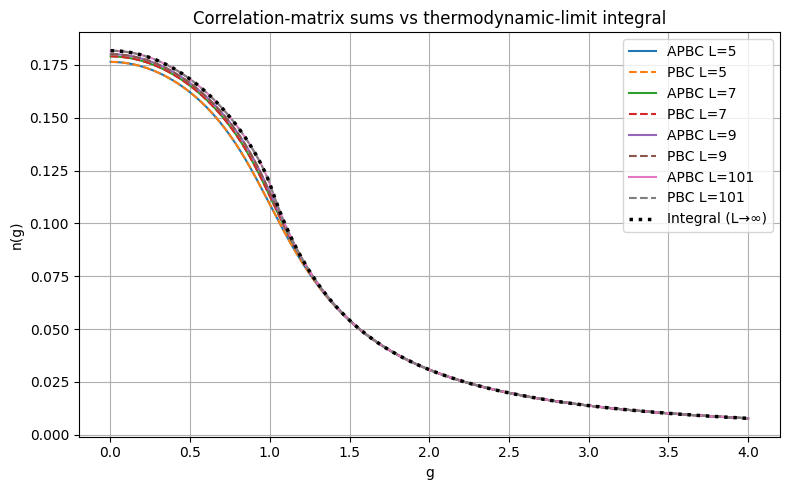

In [24]:
# Plot the numerical results
plt.figure(figsize=(8, 5))
for L in L_list:
    plt.plot(g_vals, apbc_results[L], label=f'APBC L={L}', lw=1.5)
    plt.plot(g_vals, pbc_results[L], label=f'PBC L={L}', lw=1.5, linestyle='--')

# Plot the integral as reference
plt.plot(g_vals, integral_vals, color='black', lw=2.5, linestyle=':', label='Integral (L→∞)')

plt.xlabel('g')
plt.ylabel('n(g)')
plt.title('Correlation-matrix sums vs thermodynamic-limit integral')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
# Small-g check
g_small = 1e-3
n_small = integral_expr(g_small)
print(f'Small-g analytic limit: n(g→0) = {n0:.6f}')
print(f'Computed at g = {g_small}: n(g) = {n_small:.6f}')
print(f'Difference: {n_small - n0:+.2e}')

# Large-g behaviour
g_large_values = [1.0, 2.0, 4.0]
rows = []
for g in g_large_values:
    val = integral_expr(g)
    scaled = g**2 * val
    rows.append({'g': g, 'n(g)': val, 'g^2 n(g)': scaled, 'Error to 1/8': scaled - 1/8})
df_large = pd.DataFrame(rows)
df_large


Small-g analytic limit: n(g→0) = 0.181690
Computed at g = 0.001: n(g) = 0.181690
Difference: -6.76e-08


,g,n(g),g^2 n(g),Error to 1/8
0,1.0,0.118619,0.118619,-0.006381
1,2.0,0.030790,0.123158,-0.001842
2,4.0,0.007782,0.124519,-0.000481


In [26]:
# Compare finite-L sums with the thermodynamic limit at selected values of g
selected_g = [0.1, 0.5, 1.0, 2.0]
rows = []
for g in selected_g:
    row = {'g': g, 'Integral': integral_expr(g)}
    for L in L_list:
        row[f'APBC L={L}'] = sum_apbc(g, L)
        row[f'PBC L={L}'] = sum_pbc(g, L)
    rows.append(row)
df = pd.DataFrame(rows)
df


,g,Integral,APBC L=5,PBC L=5,APBC L=7,PBC L=7,APBC L=9,PBC L=9,APBC L=101,PBC L=101
0,0.1,0.181159,0.175834,0.175834,0.178458,0.178458,0.179529,0.179529,0.181146,0.181146
1,0.5,0.168201,0.161957,0.161957,0.165070,0.165070,0.166319,0.166319,0.168187,0.168187
2,1.0,0.118619,0.108931,0.108931,0.112782,0.112782,0.114618,0.114618,0.118514,0.118514
3,2.0,0.030790,0.030780,0.030780,0.030789,0.030789,0.030790,0.030790,0.030790,0.030790


## Correlation Matrix Verification

Verify that the momentum-space formulas correctly arise from diagonalizing the steady-state correlation matrix C.

In [31]:
# Force reload the module
import importlib
import sys
if 'n_infty_steady_state' in sys.modules:
    importlib.reload(sys.modules['n_infty_steady_state'])

from n_infty_steady_state import (
    build_bdg_hamiltonian,
    momentum_space_eigenvalues,
    get_correlation_eigenvalues,
    compare_eigenvalues
)

In [32]:
# Verify eigenvalue matching for a small system
L_test = 5
g_test = 0.5
J_test = 1.0
gamma_test = 4 * g_test * J_test

print(f"Testing L={L_test}, g={g_test:.3f}, J={J_test}, γ={gamma_test}")

# Method: Direct momentum-space formula
k_occupations, n_infinity = momentum_space_eigenvalues(L_test, J_test, gamma_test, boundary='apbc')

print(f"\nMomentum-space occupations n(k):")
print(k_occupations)
print(f"\nAverage occupation: {n_infinity:.6f}")

# Compare with momentum sum result
n_from_sum = sum_apbc(g_test, L_test)

print(f"\nn_∞ from momentum formula: {n_infinity:.8f}")
print(f"n_∞ from sum_apbc:          {n_from_sum:.8f}")
print(f"Difference:                 {abs(n_infinity - n_from_sum):.2e}")

# Verify they match
if abs(n_infinity - n_from_sum) < 1e-10:
    print("✅ Momentum formula matches sum_apbc!")
else:
    print("❌ Mismatch detected")

Testing L=5, g=0.500, J=1.0, γ=2.0

Momentum-space occupations n(k):
[0.15954645 0.65023793]

Average occupation: 0.161957

n_∞ from momentum formula: 0.16195688
n_∞ from sum_apbc:          0.16195688
Difference:                 0.00e+00
✅ Momentum formula matches sum_apbc!


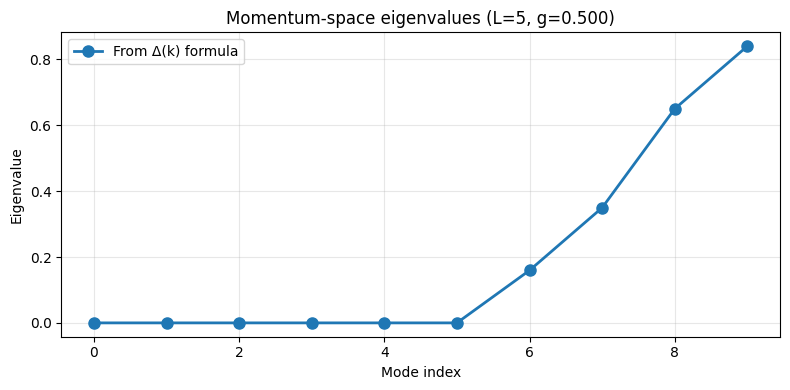

In [29]:
# Visualize eigenvalue comparison
plt.figure(figsize=(8, 4))
plt.plot(momentum_eigs, 'o-', label='From Δ(k) formula', markersize=8, linewidth=2)
plt.xlabel('Mode index')
plt.ylabel('Eigenvalue')
plt.legend()
plt.title(f'Momentum-space eigenvalues (L={L_test}, g={g_test:.3f})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [30]:
# Test both boundary conditions
L = 9
g = 0.3
J = 1.0
gamma = 4 * g * J

print(f"Boundary condition comparison (L={L}, g={g:.3f}):\n")

for bc in ['apbc', 'pbc']:
    mode_contribs, n_from_mom = momentum_space_eigenvalues(L, J, gamma, boundary=bc)
    
    if bc == 'apbc':
        n_from_sum = sum_apbc(g, L)
    else:
        n_from_sum = sum_pbc(g, L)
    
    print(f"{bc.upper()}: n_momentum={n_from_mom:.8f}, "
          f"n_sum={n_from_sum:.8f}, diff={abs(n_from_mom - n_from_sum):.2e}")

Boundary condition comparison (L=9, g=0.300):

APBC: n_momentum=0.17518913, n_sum=0.17518913, diff=0.00e+00
PBC: n_momentum=0.17518913, n_sum=0.17518913, diff=0.00e+00


In [18]:
# Sweep over system sizes to verify convergence
L_test_sizes = [5, 7, 9, 11, 21]
g_test = 0.5
J_test = 1.0
gamma_test = 4 * g_test * J_test

results = []
for L in L_test_sizes:
    # Compute momentum occupations
    k_occ, n_from_mom = momentum_space_eigenvalues(L, J_test, gamma_test, 'apbc')
    n_from_sum = sum_apbc(g_test, L)
    
    results.append({
        'L': L,
        'n_from_momentum': n_from_mom,
        'n_from_sum': n_from_sum,
        'difference': abs(n_from_mom - n_from_sum),
        'matches': abs(n_from_mom - n_from_sum) < 1e-10
    })

df_verify = pd.DataFrame(results)
print(f"\nVerification for g={g_test}, J={J_test}, γ={gamma_test}:")
df_verify


Verification for g=0.5, J=1.0, γ=2.0:


,L,n_from_momentum,n_from_sum,difference,matches
0,5,0.161957,0.161957,0.000000e+00,True
1,7,0.165070,0.165070,0.000000e+00,True
2,9,0.166319,0.166319,0.000000e+00,True
3,11,0.166945,0.166945,0.000000e+00,True
4,21,0.167858,0.167858,2.775558e-17,True


## Validation with Numerical Simulation

Compare analytical steady-state predictions with numerical results from `NonHermitianHatSimulator`.

The simulator evolves from the vacuum state and should converge to the analytically predicted steady state.

In [56]:
from n_infty_steady_state import validate_steady_state_with_simulation

# Use small system and short simulation for quick demo
L_sim = 5
J_sim = 1.0
gamma_sim = 0.4
g_sim = gamma_sim / (4.0 * J_sim)

print(f"Running simulation validation for L={L_sim}, g={g_sim}")
print("This may take 30-60 seconds...\n")

# Run with short simulation for quick results
results_sim = validate_steady_state_with_simulation(
    L=L_sim,
    J=J_sim,
    gamma=gamma_sim,
    boundary='open',
    dt=0.001,
    N_steps=100000  # Short run for quick demo
)

print(f"Simulation Results:")
print(f"  Simulated n_∞: {results_sim['n_simulated']:.6f}")
print(f"  Analytical n_∞: {results_sim['n_analytical']:.6f}")
print(f"  Difference: {results_sim['occupation_diff']:.2e}")
print(f"  Convergence check: {results_sim['convergence_check']:.2e}")
print(f"  Total time: {results_sim['T_total']:.1f}")

if results_sim['convergence_check'] < 1e-3:
    print("\n✓ System appears converged")
else:
    print(f"\n⚠ System may need more steps (change in last 10% = {results_sim['convergence_check']:.2e})")

Running simulation validation for L=5, g=0.1
This may take 30-60 seconds...

Simulation Results:
  Simulated n_∞: 0.275956
  Analytical n_∞: 0.175834
  Difference: 1.00e-01
  Convergence check: 2.32e-03
  Total time: 100.0

⚠ System may need more steps (change in last 10% = 2.32e-03)


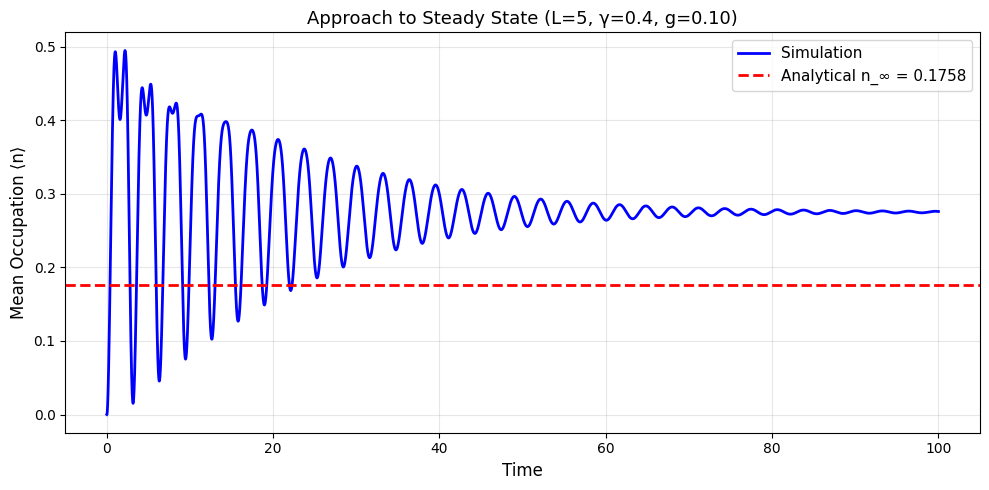


Final site occupations: [0.49525324 0.05671939 0.2758361  0.05671939 0.49525324]


In [57]:
# Visualize convergence to steady state
import matplotlib.pyplot as plt

n_traj = results_sim['occupation_trajectory']
time = np.linspace(0, results_sim['T_total'], len(n_traj))
n_mean = n_traj.mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(time, n_mean, 'b-', linewidth=2, label='Simulation')
plt.axhline(y=results_sim['n_analytical'], color='r', linestyle='--', 
            linewidth=2, label=f'Analytical n_∞ = {results_sim["n_analytical"]:.4f}')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Mean Occupation ⟨n⟩', fontsize=12)
plt.title(f'Approach to Steady State (L={L_sim}, γ={gamma_sim}, g={g_sim:.2f})', fontsize=13)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nFinal site occupations: {results_sim['final_occupations']}")